In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

from sklearn.metrics import accuracy_score

from numpy.random import seed
seed(7)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [25]:
df = pd.read_csv("processed_data18.csv") 
df.head(n=5)  # visualize the data.

Unnamed: 0         time  y        x1        x2        x3         x4  \
0           0  5/1/99 0:00  0  0.376665 -4.596435 -4.095756  13.497687   
1           1  5/1/99 0:02  0  0.475720 -4.542502 -4.018359  16.230659   
2           2  5/1/99 0:04  0  0.363848 -4.681394 -4.353147  14.127997   
3           3  5/1/99 0:06  0  0.301590 -4.758934 -4.023612  13.161566   
4           4  5/1/99 0:08  0  0.265578 -4.749928 -4.333150  15.267340   

         x5         x6        x7  ...  trend_x52  trend_x53  trend_x54  \
0 -0.118830 -20.669883  0.000732  ...        NaN        NaN        NaN   
1 -0.128733 -18.758079  0.000732  ...        NaN        NaN        NaN   
2 -0.138636 -17.836632  0.010803  ...        NaN        NaN        NaN   
3 -0.148142 -18.517601  0.002075  ...        NaN        NaN        NaN   
4 -0.155314 -17.505913  0.000732  ...        NaN        NaN        NaN   

   trend_x55  trend_x56  trend_x57  trend_x58  trend_x59  trend_x60  trend_x61  
0        NaN        NaN        NaN        NaN        NaN        NaN        NaN  
1        NaN        NaN        NaN        NaN        NaN        NaN        NaN  
2        NaN        NaN        NaN        NaN        NaN        NaN        NaN  
3        NaN        NaN        NaN        NaN        NaN        NaN        NaN  
4        NaN        NaN        NaN        NaN        NaN        NaN        NaN  

[5 rows x 612 columns]

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Columns: 612 entries, Unnamed: 0 to trend_x61
dtypes: float64(600), int64(11), object(1)
memory usage: 85.9+ MB


In [27]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [28]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


Unnamed: 0          time  y        x1         x2
256         256   5/1/99 8:32  0  1.016235  -4.058394
257         257   5/1/99 8:34  0  1.005602  -3.876199
258         258   5/1/99 8:36  0  0.933933  -3.868467
259         259   5/1/99 8:38  1  0.892311 -13.332664
260         260  5/1/99 10:50  0  0.020062  -3.987897

After shifting


y  Unnamed: 0          time        x1        x2
255  0.0         255   5/1/99 8:30  0.997107 -3.865720
256  0.0         256   5/1/99 8:32  1.016235 -4.058394
257  1.0         257   5/1/99 8:34  1.005602 -3.876199
258  1.0         258   5/1/99 8:36  0.933933 -3.868467
260  0.0         260  5/1/99 10:50  0.020062 -3.987897

In [ ]:
# Remove time column
df = df.drop(['time'], axis=1)

In [7]:
X = df.drop(['y'], axis=1)
y = df['y']

In [8]:
X
X=X.fillna(0)
X

Unnamed: 0        x1        x2        x3          x4        x5  \
0               0  0.376665 -4.596435 -4.095756   13.497687 -0.118830   
1               1  0.475720 -4.542502 -4.018359   16.230659 -0.128733   
2               2  0.363848 -4.681394 -4.353147   14.127997 -0.138636   
3               3  0.301590 -4.758934 -4.023612   13.161566 -0.148142   
4               4  0.265578 -4.749928 -4.333150   15.267340 -0.155314   
...           ...       ...       ...       ...         ...       ...   
18393       18393 -0.877441  0.786430  0.406426  135.301215  0.112295   
18394       18394 -0.843988  0.633086  0.561918  133.228949  0.141332   
18395       18395 -0.826547  0.450126  0.334582  134.977973  0.170370   
18396       18396 -0.822843  0.419383  0.387263  135.658942  0.199422   
18397       18397 -0.840981  0.582710  0.593416  136.339880  0.228460   

              x6        x7        x8        x9  ...  trend_x52  trend_x53  \
0     -20.669883  0.000732 -0.061114 -0.059966  ...        0.0        0.0   
1     -18.758079  0.000732 -0.061114 -0.059966  ...        0.0        0.0   
2     -17.836632  0.010803 -0.061114 -0.030057  ...        0.0        0.0   
3     -18.517601  0.002075 -0.061114 -0.019986  ...        0.0        0.0   
4     -17.505913  0.000732 -0.061114 -0.030057  ...        0.0        0.0   
...          ...       ...       ...       ...  ...        ...        ...   
18393  26.300392 -0.159185  0.058823 -0.080108  ...        0.0        0.0   
18394  25.678597 -0.159185  0.058823 -0.080108  ...        0.0        0.0   
18395  25.056801 -0.159185  0.048752 -0.080108  ...        0.0        0.0   
18396  24.435005 -0.159185  0.048752 -0.080108  ...        0.0        0.0   
18397  24.712960 -0.159185  0.048752 -0.070037  ...        0.0        0.0   

       trend_x54  trend_x55  trend_x56  trend_x57  trend_x58  trend_x59  \
0            0.0        0.0        0.0        0.0        0.0        0.0   
1            0.0        0.0        0.0        0.0        0.0        0.0   
2            0.0        0.0        0.0        0.0        0.0        0.0   
3            0.0        0.0        0.0        0.0        0.0        0.0   
4            0.0        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
18393        0.0        0.0        0.0        0.0        0.0        0.0   
18394        0.0        0.0        0.0        0.0        0.0        0.0   
18395        0.0        0.0        0.0        0.0        0.0        0.0   
18396        0.0        0.0        0.0        0.0        0.0        0.0   
18397        0.0        0.0        0.0        0.0        0.0        0.0   

       trend_x60  trend_x61  
0            0.0        0.0  
1            0.0        0.0  
2            0.0        0.0  
3            0.0        0.0  
4            0.0        0.0  
...          ...        ...  
18393        0.0        0.0  
18394        0.0        0.0  
18395        0.0        0.0  
18396        0.0        0.0  
18397        0.0        0.0  

[18274 rows x 610 columns]

In [9]:
X = X.drop(['Unnamed: 0'], axis=1)
X

x1        x2        x3          x4        x5         x6  \
0      0.376665 -4.596435 -4.095756   13.497687 -0.118830 -20.669883   
1      0.475720 -4.542502 -4.018359   16.230659 -0.128733 -18.758079   
2      0.363848 -4.681394 -4.353147   14.127997 -0.138636 -17.836632   
3      0.301590 -4.758934 -4.023612   13.161566 -0.148142 -18.517601   
4      0.265578 -4.749928 -4.333150   15.267340 -0.155314 -17.505913   
...         ...       ...       ...         ...       ...        ...   
18393 -0.877441  0.786430  0.406426  135.301215  0.112295  26.300392   
18394 -0.843988  0.633086  0.561918  133.228949  0.141332  25.678597   
18395 -0.826547  0.450126  0.334582  134.977973  0.170370  25.056801   
18396 -0.822843  0.419383  0.387263  135.658942  0.199422  24.435005   
18397 -0.840981  0.582710  0.593416  136.339880  0.228460  24.712960   

             x7        x8        x9       x10  ...  trend_x52  trend_x53  \
0      0.000732 -0.061114 -0.059966 -0.038189  ...        0.0        0.0   
1      0.000732 -0.061114 -0.059966 -0.038189  ...        0.0        0.0   
2      0.010803 -0.061114 -0.030057 -0.018352  ...        0.0        0.0   
3      0.002075 -0.061114 -0.019986 -0.008280  ...        0.0        0.0   
4      0.000732 -0.061114 -0.030057 -0.008280  ...        0.0        0.0   
...         ...       ...       ...       ...  ...        ...        ...   
18393 -0.159185  0.058823 -0.080108 -0.038189  ...        0.0        0.0   
18394 -0.159185  0.058823 -0.080108 -0.038189  ...        0.0        0.0   
18395 -0.159185  0.048752 -0.080108 -0.038189  ...        0.0        0.0   
18396 -0.159185  0.048752 -0.080108 -0.038189  ...        0.0        0.0   
18397 -0.159185  0.048752 -0.070037 -0.038189  ...        0.0        0.0   

       trend_x54  trend_x55  trend_x56  trend_x57  trend_x58  trend_x59  \
0            0.0        0.0        0.0        0.0        0.0        0.0   
1            0.0        0.0        0.0        0.0        0.0        0.0   
2            0.0        0.0        0.0        0.0        0.0        0.0   
3            0.0        0.0        0.0        0.0        0.0        0.0   
4            0.0        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
18393        0.0        0.0        0.0        0.0        0.0        0.0   
18394        0.0        0.0        0.0        0.0        0.0        0.0   
18395        0.0        0.0        0.0        0.0        0.0        0.0   
18396        0.0        0.0        0.0        0.0        0.0        0.0   
18397        0.0        0.0        0.0        0.0        0.0        0.0   

       trend_x60  trend_x61  
0            0.0        0.0  
1            0.0        0.0  
2            0.0        0.0  
3            0.0        0.0  
4            0.0        0.0  
...          ...        ...  
18393        0.0        0.0  
18394        0.0        0.0  
18395        0.0        0.0  
18396        0.0        0.0  
18397        0.0        0.0  

[18274 rows x 609 columns]

In [10]:
X = X.drop(['drift_x61'], axis=1)
X

x1        x2        x3          x4        x5         x6  \
0      0.376665 -4.596435 -4.095756   13.497687 -0.118830 -20.669883   
1      0.475720 -4.542502 -4.018359   16.230659 -0.128733 -18.758079   
2      0.363848 -4.681394 -4.353147   14.127997 -0.138636 -17.836632   
3      0.301590 -4.758934 -4.023612   13.161566 -0.148142 -18.517601   
4      0.265578 -4.749928 -4.333150   15.267340 -0.155314 -17.505913   
...         ...       ...       ...         ...       ...        ...   
18393 -0.877441  0.786430  0.406426  135.301215  0.112295  26.300392   
18394 -0.843988  0.633086  0.561918  133.228949  0.141332  25.678597   
18395 -0.826547  0.450126  0.334582  134.977973  0.170370  25.056801   
18396 -0.822843  0.419383  0.387263  135.658942  0.199422  24.435005   
18397 -0.840981  0.582710  0.593416  136.339880  0.228460  24.712960   

             x7        x8        x9       x10  ...  trend_x52  trend_x53  \
0      0.000732 -0.061114 -0.059966 -0.038189  ...        0.0        0.0   
1      0.000732 -0.061114 -0.059966 -0.038189  ...        0.0        0.0   
2      0.010803 -0.061114 -0.030057 -0.018352  ...        0.0        0.0   
3      0.002075 -0.061114 -0.019986 -0.008280  ...        0.0        0.0   
4      0.000732 -0.061114 -0.030057 -0.008280  ...        0.0        0.0   
...         ...       ...       ...       ...  ...        ...        ...   
18393 -0.159185  0.058823 -0.080108 -0.038189  ...        0.0        0.0   
18394 -0.159185  0.058823 -0.080108 -0.038189  ...        0.0        0.0   
18395 -0.159185  0.048752 -0.080108 -0.038189  ...        0.0        0.0   
18396 -0.159185  0.048752 -0.080108 -0.038189  ...        0.0        0.0   
18397 -0.159185  0.048752 -0.070037 -0.038189  ...        0.0        0.0   

       trend_x54  trend_x55  trend_x56  trend_x57  trend_x58  trend_x59  \
0            0.0        0.0        0.0        0.0        0.0        0.0   
1            0.0        0.0        0.0        0.0        0.0        0.0   
2            0.0        0.0        0.0        0.0        0.0        0.0   
3            0.0        0.0        0.0        0.0        0.0        0.0   
4            0.0        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
18393        0.0        0.0        0.0        0.0        0.0        0.0   
18394        0.0        0.0        0.0        0.0        0.0        0.0   
18395        0.0        0.0        0.0        0.0        0.0        0.0   
18396        0.0        0.0        0.0        0.0        0.0        0.0   
18397        0.0        0.0        0.0        0.0        0.0        0.0   

       trend_x60  trend_x61  
0            0.0        0.0  
1            0.0        0.0  
2            0.0        0.0  
3            0.0        0.0  
4            0.0        0.0  
...          ...        ...  
18393        0.0        0.0  
18394        0.0        0.0  
18395        0.0        0.0  
18396        0.0        0.0  
18397        0.0        0.0  

[18274 rows x 608 columns]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((14619, 608), (3655, 608))

In [14]:
# Feature scaling

In [15]:
cols = X_train.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])


In [16]:
# define model
model = XGBClassifier()

In [ ]:

# define evaluation procedure
#use repeated cross-validation to evaluate the model, with three repeats of 10-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

In [ ]:
model = XGBClassifier()

clf_0 = model.fit(X_train, y_train)


In [ ]:
pred_y_0 = clf_0.predict(X_test)

print(accuracy_score(pred_y_0, y_test))

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_0, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_0)

In [ ]:
# save model
model.save_model("1_XGBoost_rare_events-derivedData-all_features_13-tree2-shapely.json")

In [17]:
#load model
model.load_model("1_XGBoost_rare_events-derivedData-all_features_13-tree2-shapely.json")

In [18]:
type(y_train)

pandas.core.series.Series

In [40]:
#shapely prediction
# Get positive sample from training set -break class
positive_sample = X.loc[(df['y'] == 1)].iloc[:1]
positive_class = 1
positive_class


1

In [41]:
positive_sample

x1        x2        x3        x4       x5         x6        x7  \
257  1.005602 -3.876199 -1.074373  0.844397 -0.55305  14.738228  0.000732   

           x8        x9       x10  ...  trend_x52  trend_x53  trend_x54  \
257 -0.061114 -0.030057  0.001791  ...   9.243888  -6.191106  -5.072946   

     trend_x55  trend_x56  trend_x57  trend_x58  trend_x59  trend_x60  \
257 -47.280866  31.096881   4.572061   0.027805   4.057599   0.007263   

     trend_x61  
257   0.034483  

[1 rows x 608 columns]

In [42]:
# Get negative sample from training set -normal class
negative_sample = X.loc[(df['y'] ==0)].iloc[:1]
negative_class = 0
negative_class

0

In [43]:
negative_sample

x1        x2        x3         x4       x5         x6        x7  \
0  0.376665 -4.596435 -4.095756  13.497687 -0.11883 -20.669883  0.000732   

         x8        x9       x10  ...  trend_x52  trend_x53  trend_x54  \
0 -0.061114 -0.059966 -0.038189  ...        0.0        0.0        0.0   

   trend_x55  trend_x56  trend_x57  trend_x58  trend_x59  trend_x60  trend_x61  
0        0.0        0.0        0.0        0.0        0.0        0.0        0.0  

[1 rows x 608 columns]

In [44]:
# Prediction for positive sample
print(f"{model.predict_proba(positive_sample.values)}")


[[0.40727627 0.5927237 ]]


In [45]:
# Prediction for negative sample
print(f"{model.predict_proba(negative_sample.values)}")
# [[0.99280576, 0.00719424]]

[[0.12541568 0.8745843 ]]


In [46]:
import shap

# Initialize TreeExplainer
explainer = shap.TreeExplainer(model)

In [47]:
# Get Shapley values for the positive sample
shap_values_positive = explainer.shap_values(positive_sample)
shap_values_positive

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


array([[ 0.00000000e+00, -7.12492764e-02, -2.85285022e-02,
        -5.52722812e-03, -6.12635687e-02,  7.85038806e-03,
         0.00000000e+00,  0.00000000e+00,  1.64767150e-02,
        -2.04937868e-02,  0.00000000e+00,  0.00000000e+00,
         1.08588636e-02,  0.00000000e+00,  3.73045243e-02,
         0.00000000e+00, -1.60147622e-02,  3.43688518e-01,
         0.00000000e+00,  0.00000000e+00, -4.79690265e-03,
         3.86716612e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.59036252e-04,  1.02277268e-02,
         0.00000000e+00, -1.62200857e-04,  0.00000000e+00,
        -8.77812970e-03,  0.00000000e+00,  0.00000000e+00,
         1.32207675e-02,  2.24292316e-02,  0.00000000e+00,
         0.00000000e+00,  2.14175531e-03, -1.04924049e-02,
         0.00000000e+00,  4.42138314e-02,  5.09411991e-02,
         0.00000000e+00,  0.00000000e+00, -2.31746584e-02,
        -5.89874294e-03,  0.00000000e+00, -2.28170364e-04,
         0.00000000e+00, -2.97832768e-03,  0.00000000e+0

In [48]:
# Get Shapley values for the negative sample
shap_values_negative = explainer.shap_values(negative_sample)
shap_values_negative

array([[ 0.00000000e+00, -6.32585436e-02, -2.55629182e-01,
        -3.35975783e-04,  7.42460042e-03, -6.34396775e-03,
         0.00000000e+00,  0.00000000e+00,  2.79238243e-02,
        -8.37919116e-03,  0.00000000e+00,  0.00000000e+00,
        -7.22713321e-02,  0.00000000e+00,  2.17254497e-02,
         0.00000000e+00, -3.32820341e-02, -2.06112600e-04,
         0.00000000e+00,  0.00000000e+00, -4.79690265e-03,
         3.86716612e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -3.17316240e-04,  1.49128977e-02,
         0.00000000e+00, -1.34232134e-04,  0.00000000e+00,
        -4.35518334e-03,  0.00000000e+00,  0.00000000e+00,
        -1.40191917e-03,  6.56120703e-02,  0.00000000e+00,
         0.00000000e+00,  5.53245749e-03, -3.75021924e-03,
         0.00000000e+00, -8.46056044e-02, -3.13875377e-02,
         0.00000000e+00,  0.00000000e+00,  4.49413434e-02,
        -1.76372472e-03,  0.00000000e+00, -1.78538583e-04,
         0.00000000e+00, -2.97832768e-03,  0.00000000e+0

In [51]:
print(f"{shap_values_positive[0]}")
# [0.0089429 , 0.01352552, 0.1930548 , 0.13567828, 0.03822685, 0.1438681 , 0.05501076, 0.02176474]


[ 0.00000000e+00 -7.12492764e-02 -2.85285022e-02 -5.52722812e-03
 -6.12635687e-02  7.85038806e-03  0.00000000e+00  0.00000000e+00
  1.64767150e-02 -2.04937868e-02  0.00000000e+00  0.00000000e+00
  1.08588636e-02  0.00000000e+00  3.73045243e-02  0.00000000e+00
 -1.60147622e-02  3.43688518e-01  0.00000000e+00  0.00000000e+00
 -4.79690265e-03  3.86716612e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.59036252e-04  1.02277268e-02  0.00000000e+00
 -1.62200857e-04  0.00000000e+00 -8.77812970e-03  0.00000000e+00
  0.00000000e+00  1.32207675e-02  2.24292316e-02  0.00000000e+00
  0.00000000e+00  2.14175531e-03 -1.04924049e-02  0.00000000e+00
  4.42138314e-02  5.09411991e-02  0.00000000e+00  0.00000000e+00
 -2.31746584e-02 -5.89874294e-03  0.00000000e+00 -2.28170364e-04
  0.00000000e+00 -2.97832768e-03  0.00000000e+00  0.00000000e+00
 -8.83027446e-04  0.00000000e+00  0.00000000e+00 -2.36419169e-03
  1.56124672e-02 -6.35888064e-05 -2.84905061e-02  0.00000000e+00
  0.00000000e+00 -2.08775

In [53]:
print(f"{shap_values_negative[0]}")
# [ 0.00137619,  0.00663525, -0.14600755, -0.11618931, -0.01479767, -0.07345027, -0.02249973, -0.00341222]

[ 0.00000000e+00 -6.32585436e-02 -2.55629182e-01 -3.35975783e-04
  7.42460042e-03 -6.34396775e-03  0.00000000e+00  0.00000000e+00
  2.79238243e-02 -8.37919116e-03  0.00000000e+00  0.00000000e+00
 -7.22713321e-02  0.00000000e+00  2.17254497e-02  0.00000000e+00
 -3.32820341e-02 -2.06112600e-04  0.00000000e+00  0.00000000e+00
 -4.79690265e-03  3.86716612e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.17316240e-04  1.49128977e-02  0.00000000e+00
 -1.34232134e-04  0.00000000e+00 -4.35518334e-03  0.00000000e+00
  0.00000000e+00 -1.40191917e-03  6.56120703e-02  0.00000000e+00
  0.00000000e+00  5.53245749e-03 -3.75021924e-03  0.00000000e+00
 -8.46056044e-02 -3.13875377e-02  0.00000000e+00  0.00000000e+00
  4.49413434e-02 -1.76372472e-03  0.00000000e+00 -1.78538583e-04
  0.00000000e+00 -2.97832768e-03  0.00000000e+00  0.00000000e+00
 -6.94743474e-04  0.00000000e+00  0.00000000e+00 -2.36419169e-03
  1.59490053e-02 -1.41982251e-04  1.13716900e-01  0.00000000e+00
  0.00000000e+00 -3.12230

In [57]:
# It is recommended to run this commands on a Jupyter Notebook
shap.initjs()

# Plot for positive sample
shap.force_plot(explainer.expected_value, shap_values_positive, positive_sample)


In [62]:
shap.force_plot(explainer.expected_value, shap_values_positive, 
                positive_sample,show=False,matplotlib=True).savefig('positive.png')

In [63]:
f=shap.force_plot(explainer.expected_value, shap_values_positive, positive_sample, show=False)
shap.save_html("index.htm", f)

In [64]:
# Plot for negative sample
shap.force_plot(explainer.expected_value, shap_values_negative, negative_sample)

In [66]:
f=shap.force_plot(explainer.expected_value, shap_values_negative, negative_sample, show=False)
shap.save_html("index_neg.htm", f)

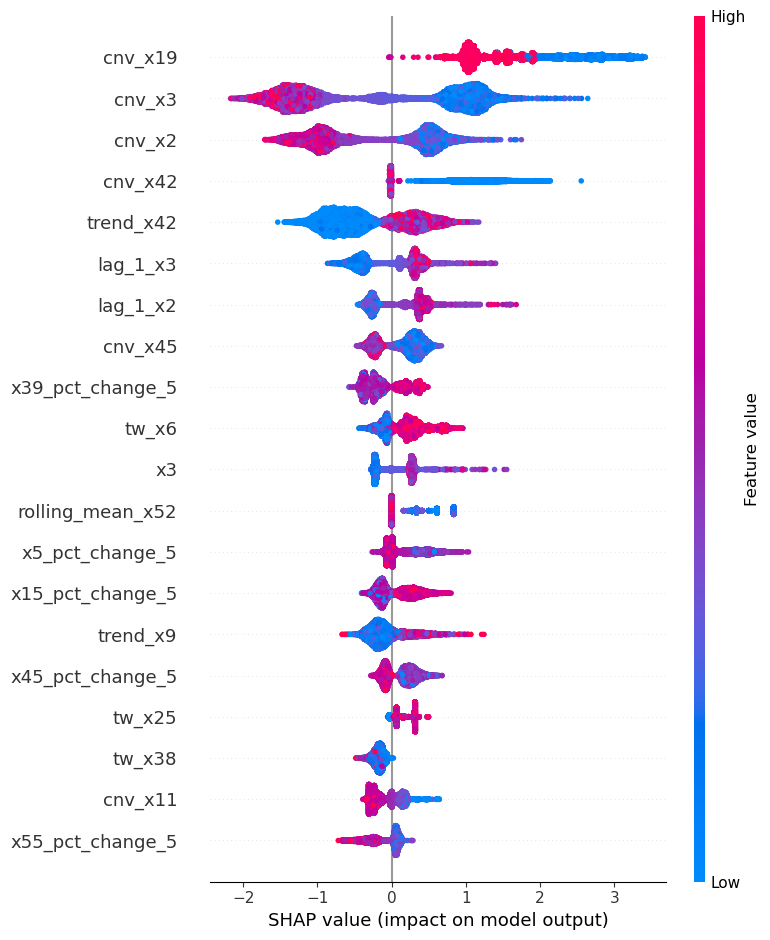

In [69]:
# First, we need the shap values for each sample in the training set
shap_values = explainer.shap_values(X)
# Then, we can plot the summary_plot w.r.t the positive class
shap.summary_plot(shap_values, X)

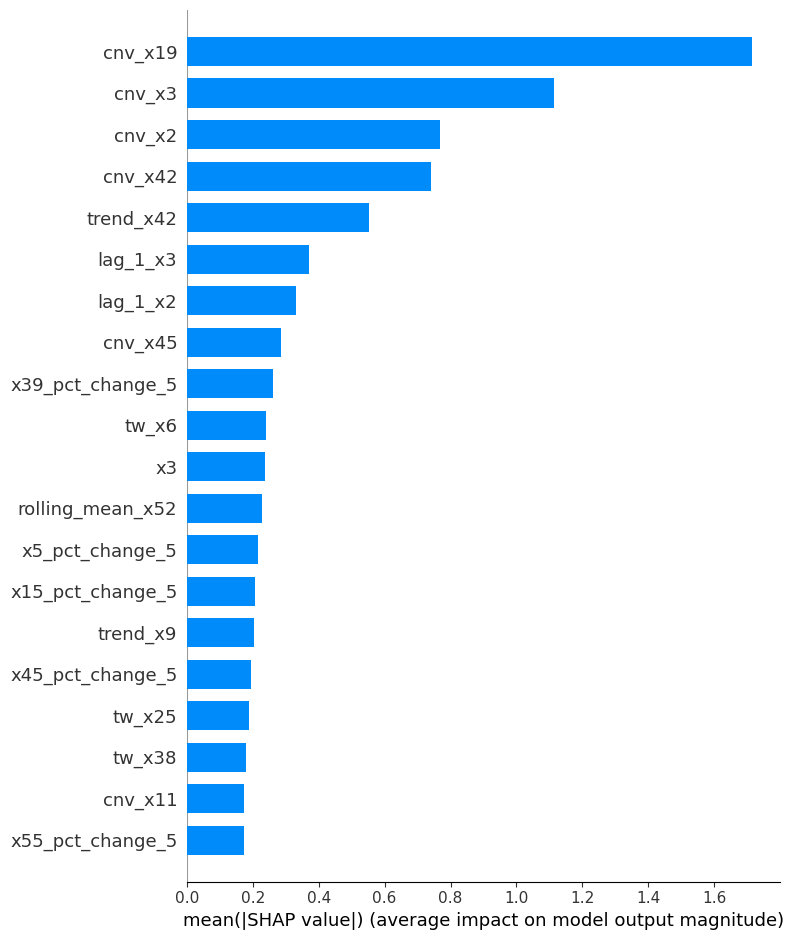

In [78]:
shap.summary_plot(shap_values, X, plot_type="bar")

<AxesSubplot:>

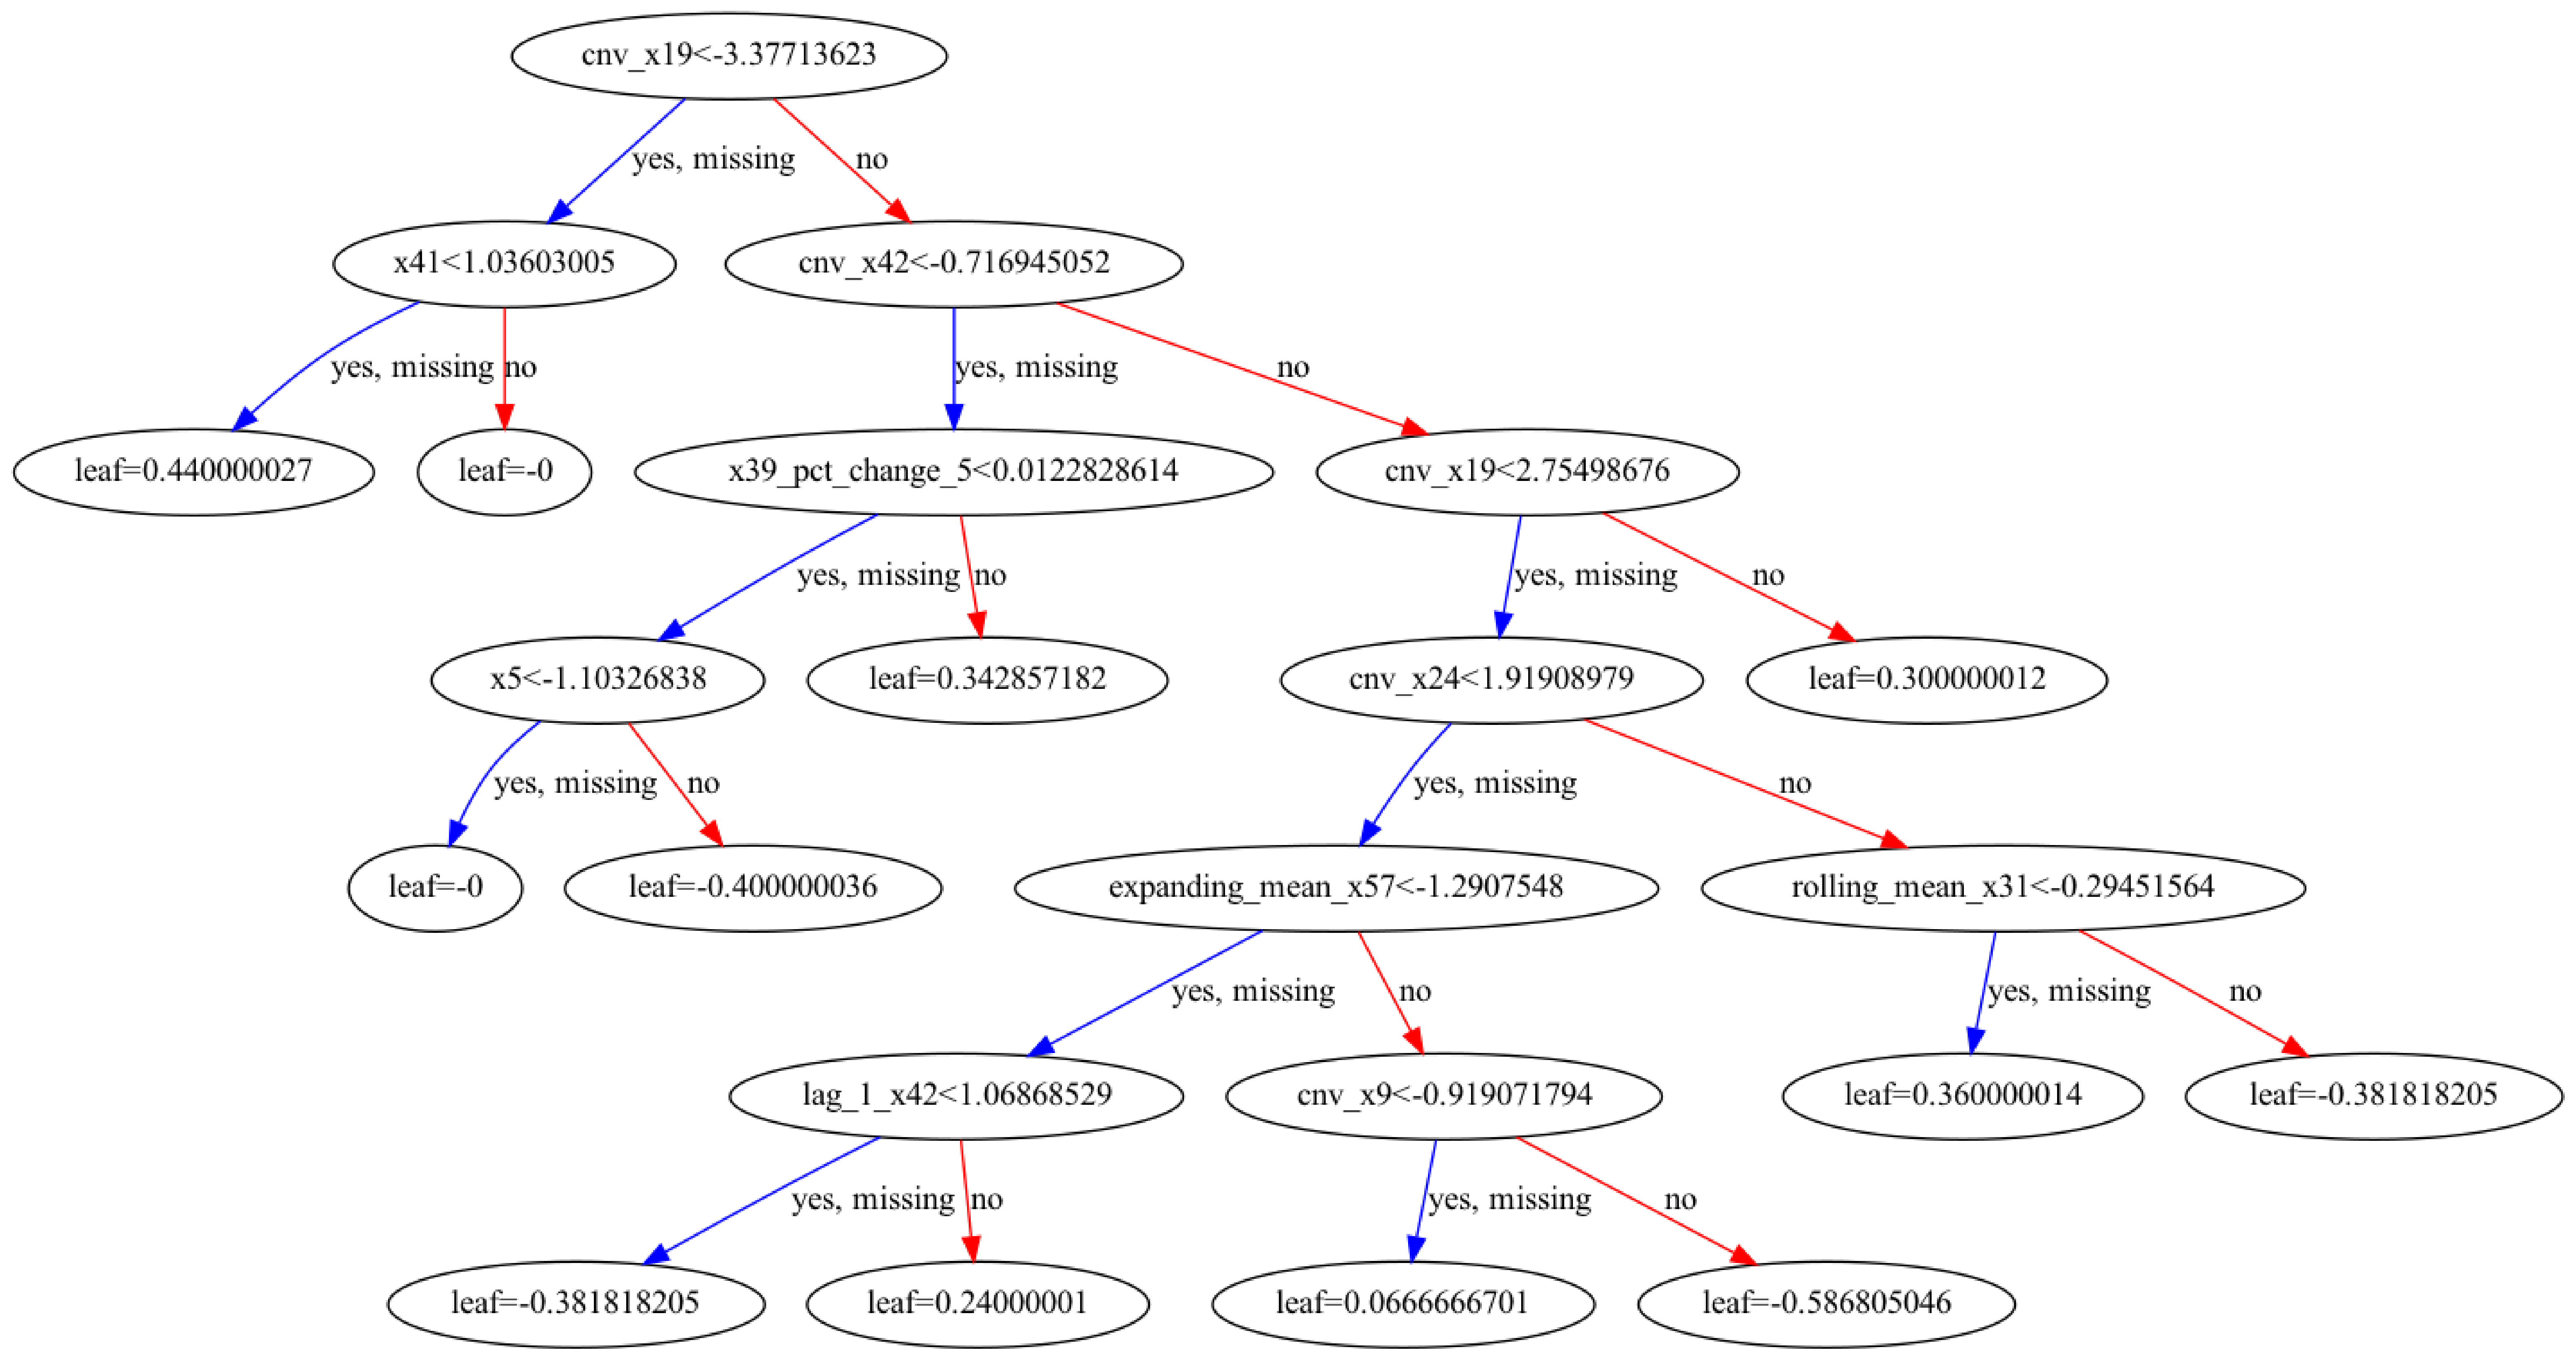

In [67]:
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50

plot_tree(model)
#yes, missing here means this tree has handled missing values

# Weighted XGBoost for Class Imbalance


In [ ]:
# define model
#scale_pos_weight=total_negative_examples / total_positive_examples
#total number of examples in the majority class / total number of examples in the minority class.
#18274/124=147.37
model = XGBClassifier(scale_pos_weight=147)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

In [ ]:
clf_1 = model.fit(X_train, y_train)
pred_y_1 = clf_1.predict(X_test)

print(accuracy_score(pred_y_1, y_test))

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_1, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_1)

In [ ]:
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50

plot_tree(model)
#yes, missing here means this tree has handled missing values

# Tune with GridSearch CV

In [ ]:
# define grid
weights = [1, 10, 25, 50, 75, 99, 100,700,800,1000,2000]
param_grid = dict(scale_pos_weight=weights)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [ ]:
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [17]:
# define model
model = XGBClassifier(scale_pos_weight=2000)


In [ ]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

In [80]:
clf_2 = model.fit(X_train, y_train)
pred_y_2 = clf_2.predict(X_test)

print(accuracy_score(pred_y_2, y_test))

0.9926128590971273


In [81]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_2, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_2)

              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00      3608
     class 1       0.81      0.55      0.66        47

    accuracy                           0.99      3655
   macro avg       0.90      0.78      0.83      3655
weighted avg       0.99      0.99      0.99      3655



array([[3602,    6],
       [  21,   26]])

In [23]:
X.to_excel("X.xlsx")

In [107]:
# save model
#model.save_model("3_XGBoost_rare_events-derivedData-all_features_13-tree2-shapely.json")

#load model
model.load_model("3_XGBoost_rare_events-derivedData-all_features_13-tree2-shapely.json")

#shapely prediction
# Get positive sample from training set -break class-  for an arbitrary instance-14
positive_sample = X.loc[(df['y'] == 1)].iloc[[14]]
print("positive sample",positive_sample)


positive_class = 1
positive_class

# Get negative sample from training set -normal class
negative_sample = X.loc[(df['y'] ==0)].iloc[[14]]
print("negative sample",negative_sample)

negative_class = 0
negative_class

# Prediction for positive sample
print(f"{model.predict_proba(positive_sample.values)}")

# Prediction for negative sample
print(f"{model.predict_proba(negative_sample.values)}")
# [[0.99280576, 0.00719424]]

import shap

# Initialize TreeExplainer
explainer = shap.TreeExplainer(model)

# Get Shapley values for the positive sample
shap_values_positive = explainer.shap_values(positive_sample)
print("shapely values positive", shap_values_positive)

# Get Shapley values for the negative sample
shap_values_negative = explainer.shap_values(negative_sample)
print("shapely values negative", shap_values_negative)

print(f"{shap_values_positive[0]}")
# [0.0089429 , 0.01352552, 0.1930548 , 0.13567828, 0.03822685, 0.1438681 , 0.05501076, 0.02176474]

print(f"{shap_values_negative[0]}")
# [ 0.00137619,  0.00663525, -0.14600755, -0.11618931, -0.01479767, -0.07345027, -0.02249973, -0.00341222]

# It is recommended to run this commands on a Jupyter Notebook
shap.initjs()

# Plot for positive sample -local interpretation
#shap.force_plot(explainer.expected_value, shap_values_positive, positive_sample)
f=shap.force_plot(explainer.expected_value, shap_values_positive, positive_sample, show=False)
shap.save_html("index_positive.htm", f)

positive sample             x1        x2        x3         x4        x5         x6        x7  \
1342 -0.677342  0.625081  5.972151 -131.19874 -0.086024 -66.334923  0.010803   

            x8        x9       x10  ...  trend_x52  trend_x53  trend_x54  \
1342 -0.000993  0.009922  0.001791  ...  -2.939504  -6.856144   2.792921   

      trend_x55   trend_x56  trend_x57  trend_x58  trend_x59  trend_x60  \
1342 -20.510232 -118.528704  -0.956311   0.026064   3.145139   0.005863   

      trend_x61  
1342        0.0  

[1 rows x 608 columns]
negative sample           x1        x2       x3         x4        x5        x6        x7  \
14  0.469631 -4.398065 -4.02846  29.857276 -0.227122 -6.799614 -0.019409   

          x8        x9       x10  ...  trend_x52  trend_x53  trend_x54  \
14 -0.051043 -0.110016 -0.088239  ...  10.152605   0.117842  -4.946862   

    trend_x55  trend_x56  trend_x57  trend_x58  trend_x59  trend_x60  \
14 -34.437175  34.223219   3.779207   0.032773   1.499846   0.006178 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [47]:

# Calculates the SHAP values - It takes some time
shap_values = explainer(X)

shap_values

.values =
array([[ 0.00280722, -0.16488855, -0.6328378 , ...,  0.00370263,
         0.01053973,  0.        ],
       [ 0.00189573, -0.14930691, -0.61605984, ...,  0.00370263,
         0.01020367,  0.        ],
       [ 0.00189573, -0.15346026, -0.6157538 , ...,  0.00370263,
         0.00947822,  0.        ],
       ...,
       [ 0.00281875,  0.23971954,  0.33757502, ...,  0.00378996,
         0.00470565,  0.        ],
       [ 0.00281875,  0.23986156,  0.33757502, ...,  0.00378996,
         0.00470565,  0.        ],
       [ 0.00281875,  0.24129024,  0.35723338, ...,  0.00378996,
         0.01262213,  0.        ]], dtype=float32)

.base_values =
array([4.0742745, 4.0742745, 4.0742745, ..., 4.0742745, 4.0742745,
       4.0742745], dtype=float32)

.data =
array([[ 0.37666549, -4.5964348 , -4.0957558 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.47572049, -4.5425018 , -4.0183588 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.36384849, -4.6813938 , -4

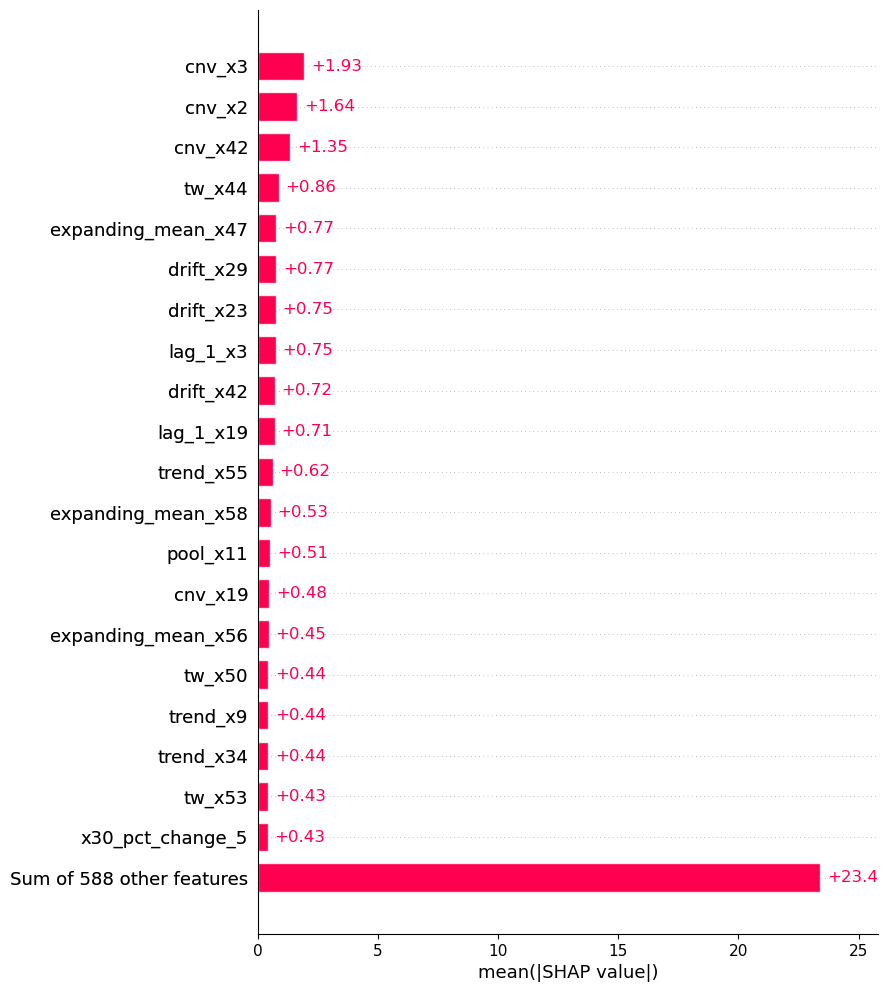

In [55]:
# Plots this view-global interpretation
shap.plots.bar(shap_values, max_display=21)

In [42]:
# Plot for negative sample -local interpretation
f=shap.force_plot(explainer.expected_value, shap_values_negative, negative_sample, show=False)
shap.save_html("index_negative.htm", f)

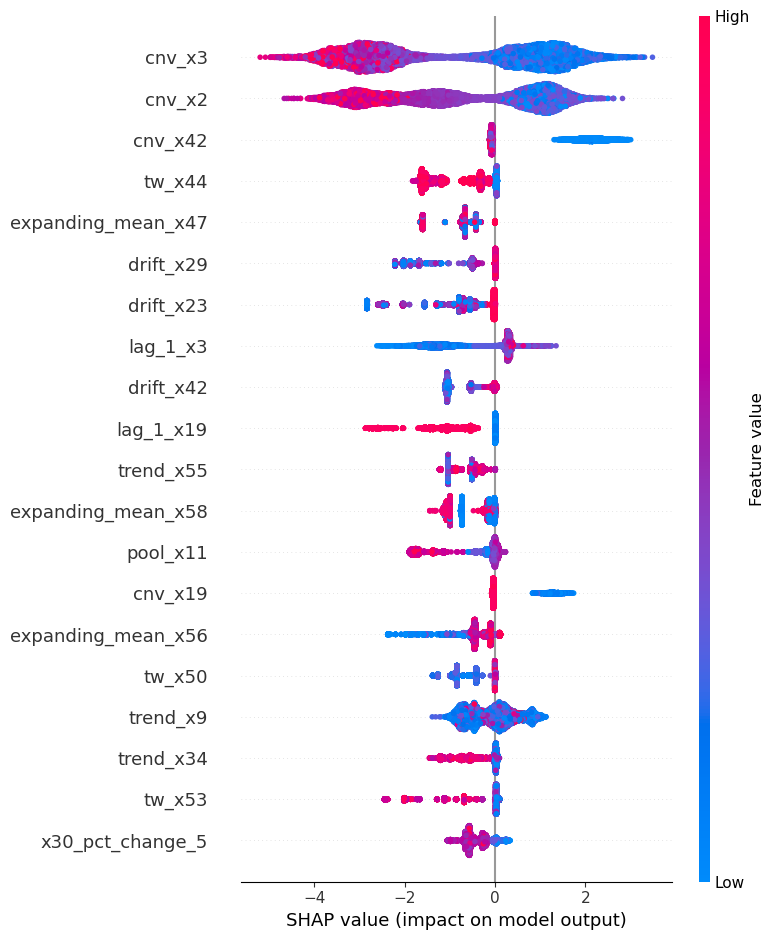

In [25]:
#plot summary-global interpretation
#shap_values = explainer.shap_values(X)
# Then, we can plot the summary_plot w.r.t the positive class
shap.summary_plot(shap_values, X)



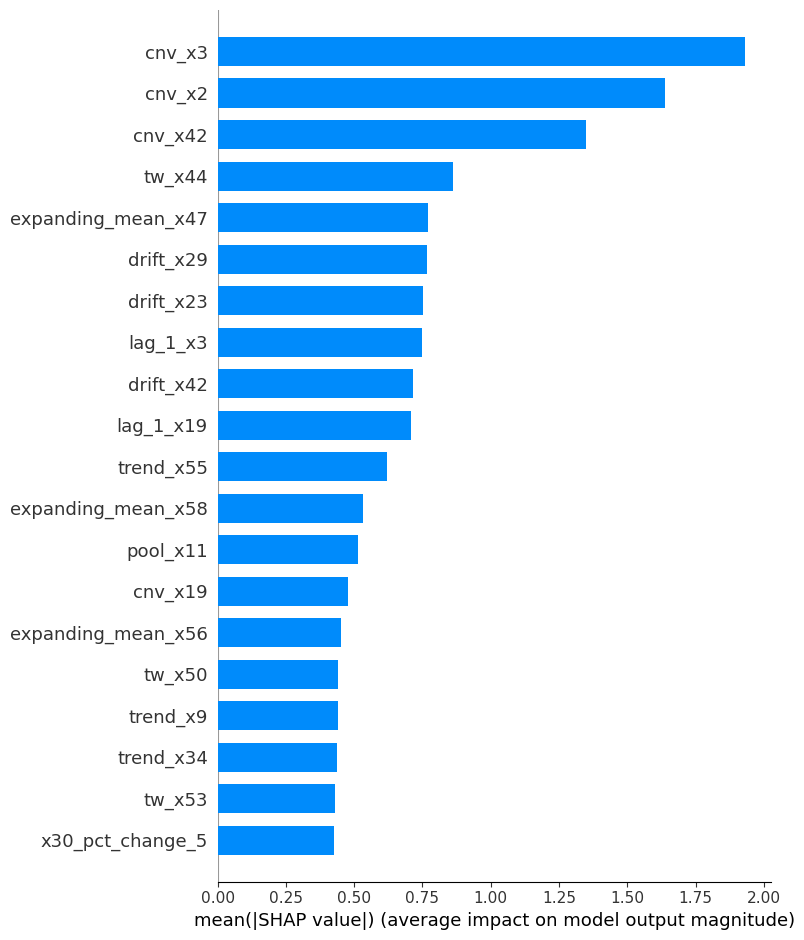

In [54]:
#plot summary-global interpretation
shap.summary_plot(shap_values, X, plot_type="bar", max_display=20)

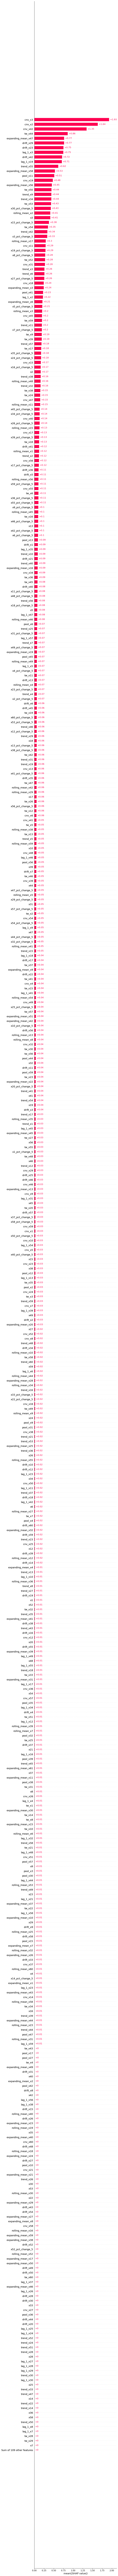

In [61]:
#SHAP local evaluation
shap.plots.bar(shap_values,max_display=500)


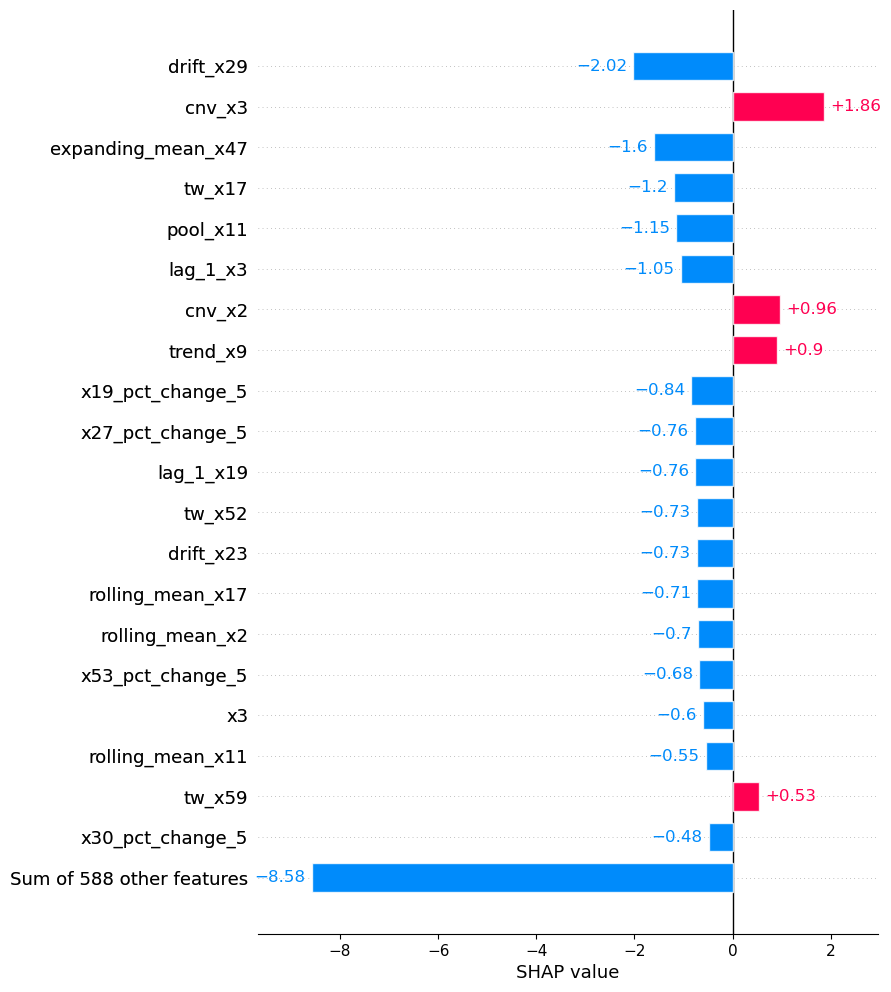

In [81]:
#SHAP local evaluation- a normal event
shap.plots.bar(shap_values[14],max_display=21)


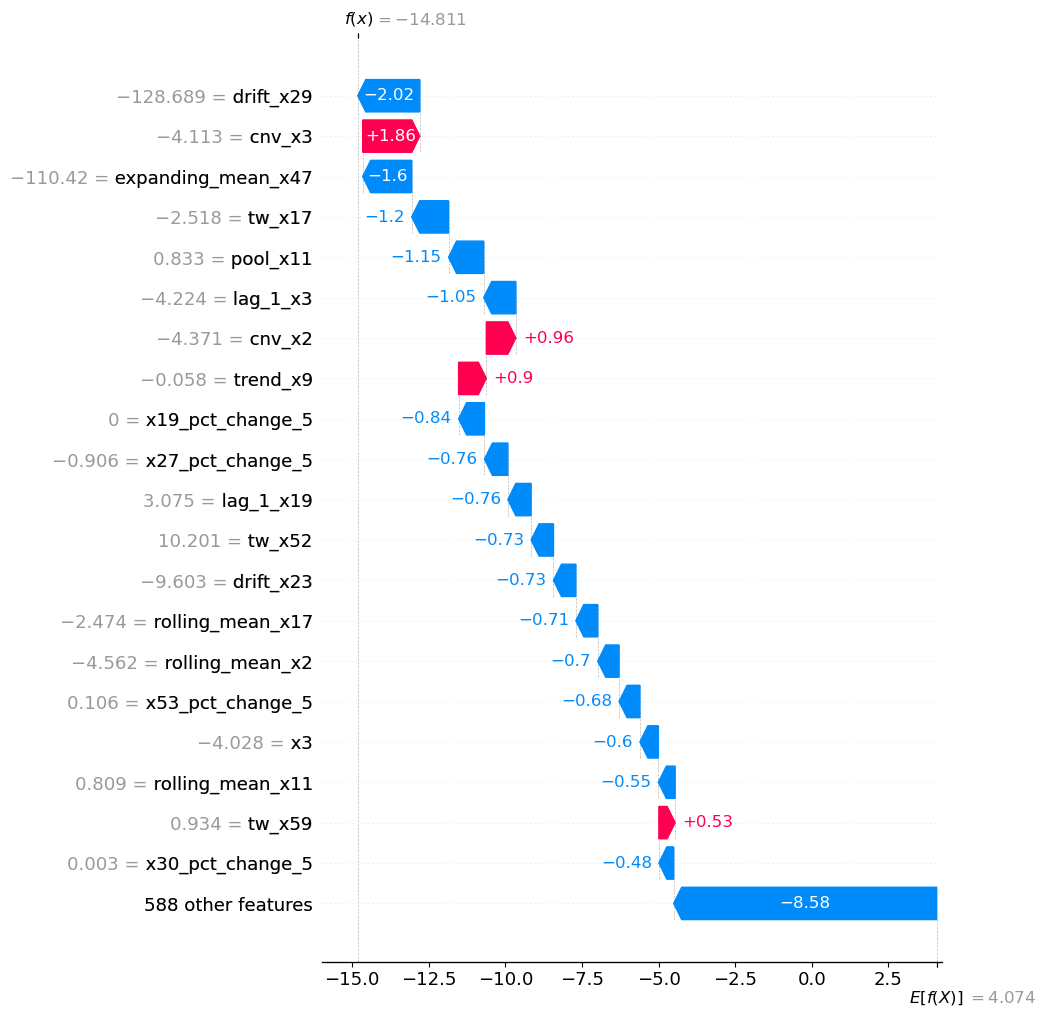

In [118]:
shap.plots.waterfall(shap_values[14], max_display=21)


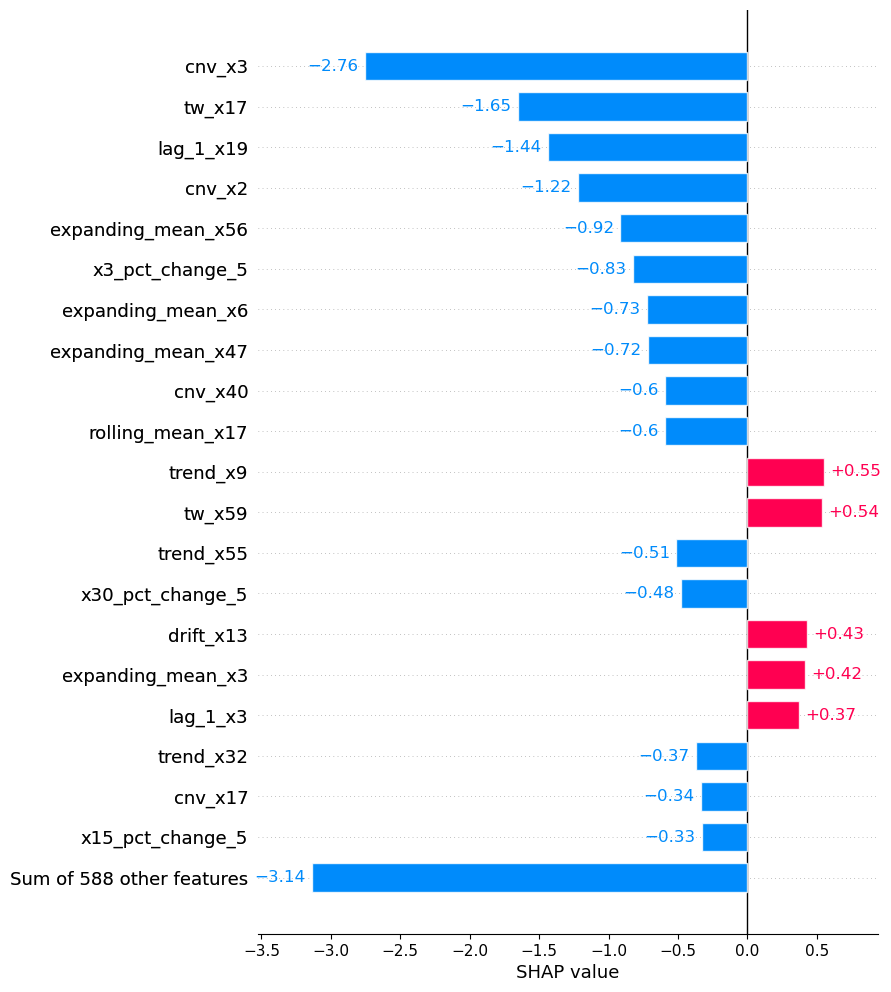

In [116]:
#SHAP local evaluation- a break event
shap.plots.bar(shap_values[1335],max_display=21)
#shap_values[1335]- row 1342 is now in row 1335 due to shifting operation

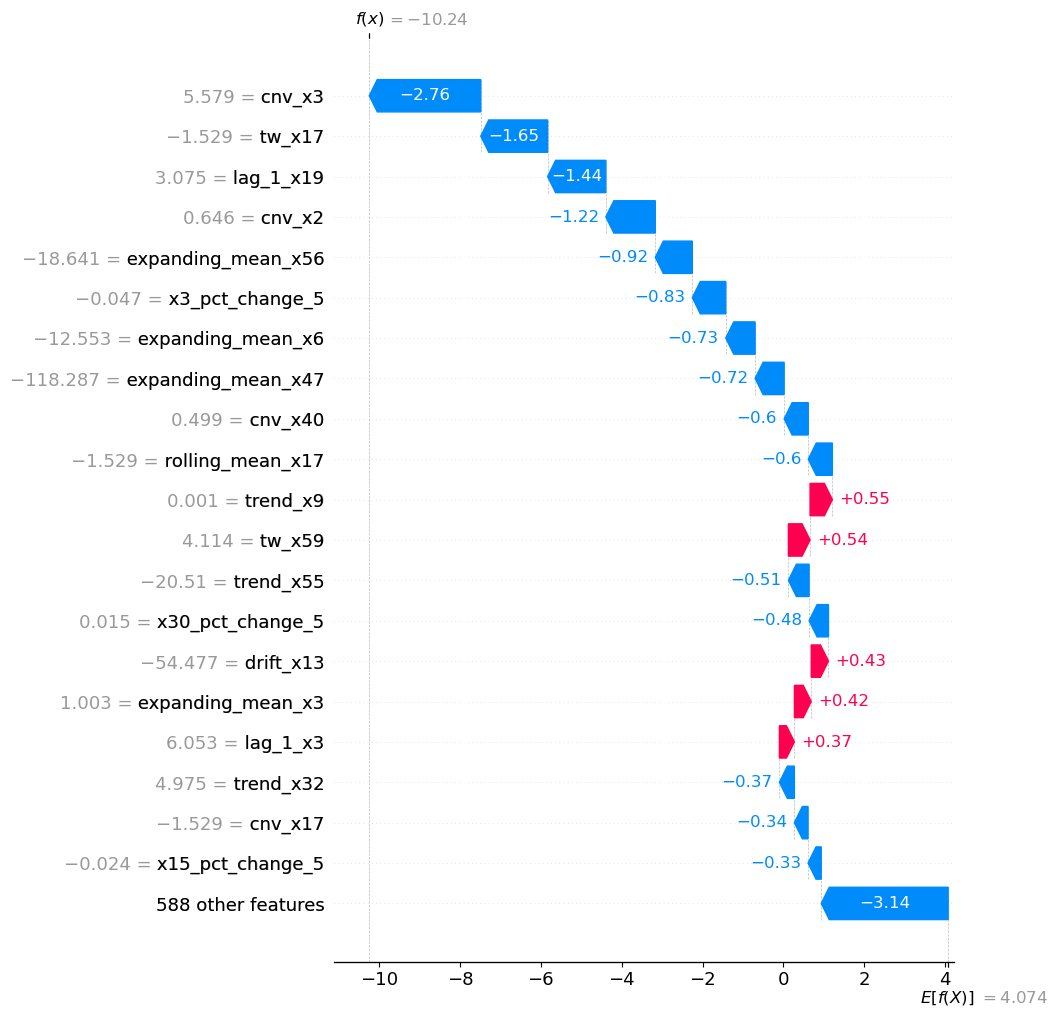

In [117]:
shap.plots.waterfall(shap_values[1335], max_display=21)


<AxesSubplot:>

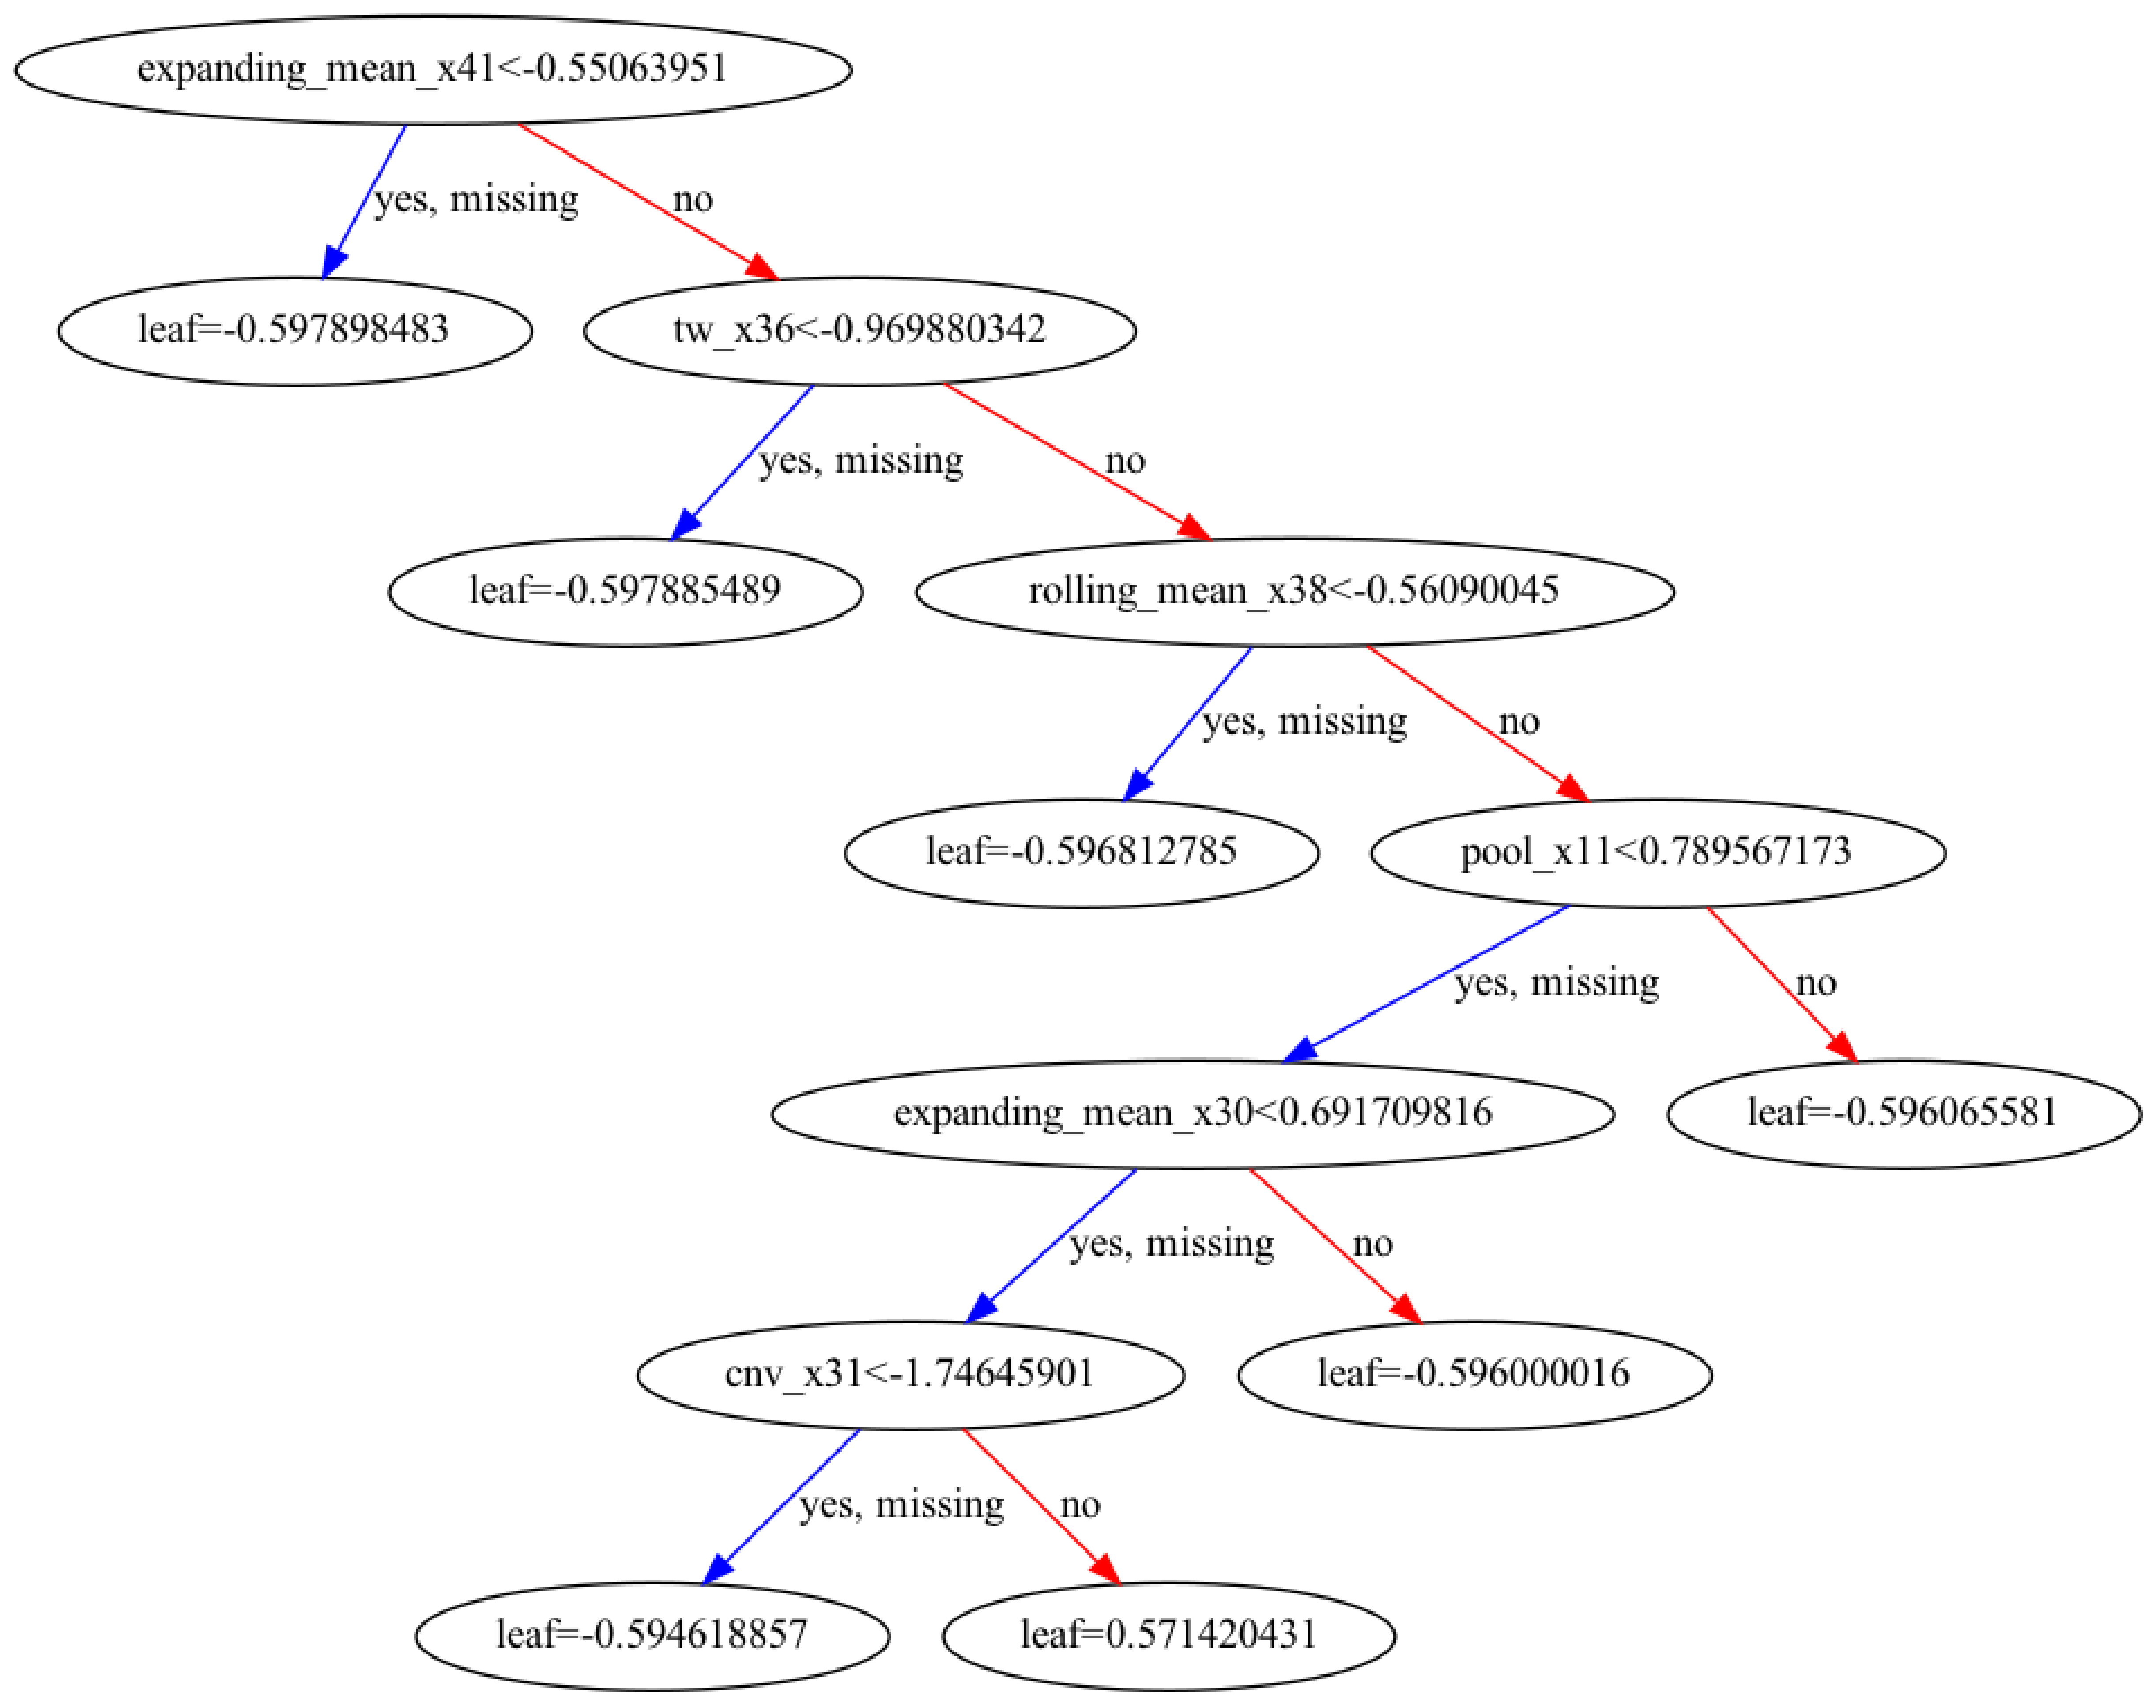

In [132]:
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50

plot_tree(model)
#yes, missing here means this tree has handled missing values

In [23]:
#https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.feature_importances_
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.feature_importances_[i].round(5))
    
#While coefficients are great for telling us what will happen when we change the value of an input feature, 
#by themselves they are not a great way to measure the overall importance of a feature. 
#This is because the value of each coefficient depends on the scale of the input features. 
#If for example we were to measure the age of a home in minutes instead of years, then the coefficients for the 
#HouseAge feature would become 0.0115 / (365∗24∗60) = 2.18e-8. 
#Clearly the number of years since a house was built is not more important than the number of minutes, 
#yet its coefficient value is much larger. This means that the magnitude of a coefficient is not necessarily 
#a good measure of a feature’s importance in a linear model.
#https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

Model coefficients:

x1 = 0.00508
x2 = 0.00024
x3 = 0.0012
x4 = 5e-05
x5 = 0.00698
x6 = 0.0006
x7 = 0.0
x8 = 0.00096
x9 = 0.00108
x10 = 5e-05
x11 = 0.0
x12 = 0.00024
x13 = 0.00052
x14 = 0.0
x15 = 0.0004
x16 = 1e-05
x17 = 0.00071
x18 = 0.00015
x19 = 8e-05
x20 = 0.00017
x21 = 0.00032
x22 = 0.01162
x23 = 0.00064
x24 = 0.00183
x25 = 0.0
x26 = 0.00016
x27 = 0.00255
x28 = 0.0
x29 = 9e-05
x30 = 0.00187
x31 = 6e-05
x32 = 0.00015
x33 = 0.00019
x34 = 1e-04
x35 = 4e-05
x36 = 0.0
x37 = 3e-05
x38 = 0.00073
x39 = 8e-05
x40 = 0.0
x41 = 0.00015
x42 = 6e-05
x43 = 0.0
x44 = 0.00131
x45 = 1e-04
x46 = 9e-05
x47 = 0.00012
x48 = 9e-05
x49 = 0.00049
x50 = 0.0
x51 = 0.0
x52 = 0.00019
x53 = 0.00021
x54 = 0.00026
x55 = 0.0
x56 = 9e-05
x57 = 0.0
x58 = 0.0
x59 = 0.00019
x60 = 0.0
x61 = 0.0
lag_1_x1 = 0.0
lag_1_x2 = 0.00106
lag_1_x3 = 0.00127
lag_1_x4 = 0.00063
lag_1_x5 = 0.00017
lag_1_x6 = 0.00024
lag_1_x7 = 0.0
lag_1_x8 = 0.0
lag_1_x9 = 0.00495
lag_1_x10 = 0.00178
lag_1_x11 = 3e-05
lag_1_x12 = 3e-05
lag_1_x13 = 

pool_x55 = 0.0
pool_x56 = 0.00086
pool_x57 = 2e-05
pool_x58 = 0.0
pool_x59 = 6e-05
pool_x60 = 0.0
drift_x1 = 0.00125
drift_x2 = 0.00142
drift_x3 = 0.00012
drift_x4 = 0.00066
drift_x5 = 0.00094
drift_x6 = 1e-05
drift_x7 = 0.00103
drift_x8 = 0.00092
drift_x9 = 0.00189
drift_x10 = 0.00583
drift_x11 = 0.00204
drift_x12 = 8e-05
drift_x13 = 0.00036
drift_x14 = 0.00154
drift_x15 = 1e-05
drift_x16 = 0.00095
drift_x17 = 0.00162
drift_x18 = 0.00175
drift_x19 = 0.00101
drift_x20 = 0.00172
drift_x21 = 0.00048
drift_x22 = 3e-05
drift_x23 = 0.01107
drift_x24 = 0.0
drift_x25 = 0.00023
drift_x26 = 0.00138
drift_x27 = 0.01404
drift_x28 = 2e-05
drift_x29 = 0.00336
drift_x30 = 4e-05
drift_x31 = 0.00046
drift_x32 = 0.0
drift_x33 = 0.00712
drift_x34 = 0.00036
drift_x35 = 0.00166
drift_x36 = 0.00521
drift_x37 = 0.00084
drift_x38 = 0.01647
drift_x39 = 1e-04
drift_x40 = 0.00127
drift_x41 = 0.00216
drift_x42 = 0.00615
drift_x43 = 0.00017
drift_x44 = 1e-05
drift_x45 = 0.00125
drift_x46 = 0.00067
drift_x47 = 0.0

In [129]:
#Feature importances based on xgboost gain
import numpy as np

print("Feature importances based on xgboost gain(top 20 features):\n")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order

for i in range(20):  # Print the top 20 features
    feature_index = indices[i]
    importance_value = importances[feature_index].round(5)
    feature_name = X.columns[feature_index]
    print(f"{feature_name} = {importance_value}")


Feature importances based on xgboost total gain(top 20 features):

lag_1_x42 = 0.061069998890161514
lag_1_x39 = 0.02988000027835369
cnv_x29 = 0.027230000123381615
rolling_mean_x32 = 0.02459999918937683
lag_1_x57 = 0.02377999946475029
tw_x14 = 0.020800000056624413
trend_x55 = 0.016750000417232513
drift_x38 = 0.01647000014781952
expanding_mean_x41 = 0.014440000057220459
drift_x27 = 0.014039999805390835
expanding_mean_x30 = 0.013829999603331089
tw_x44 = 0.013690000399947166
tw_x39 = 0.01286999974399805
expanding_mean_x39 = 0.012769999913871288
trend_x5 = 0.012690000236034393
x48_pct_change_5 = 0.01245999988168478
tw_x36 = 0.01233999989926815
x22 = 0.011620000004768372
expanding_mean_x31 = 0.01133000012487173
drift_x23 = 0.011070000007748604


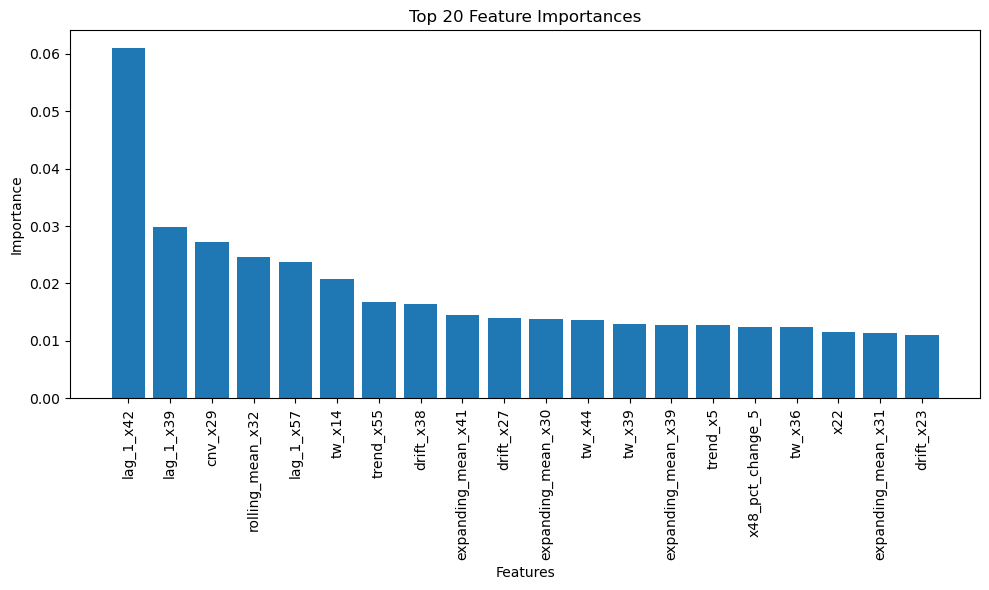

In [136]:
#Feature importances based on xgboost gain

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))  # Set the size of the plot

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order
top_features = indices[:20]  # Select the top 20 features

feature_names = X.columns[top_features]
importance_values = importances[top_features]

plt.bar(feature_names, importance_values)  # Create the bar plot

plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 20 Feature Importances')

plt.tight_layout()  # Adjust spacing between subplots and labels
plt.show()  # Display the plot


In [143]:
#Feature importances based on xgboost total-cover

import numpy as np
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.get_booster().get_score(importance_type='total_cover'))
    


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



trend_x34 = {'x1': 27195.568359375, 'x2': 838.78515625, 'x3': 5591.6533203125, 'x4': 33.74614715576172, 'x5': 15224.1552734375, 'x6': 21.459449768066406, 'x8': 205.4708709716797, 'x9': 1343.9013671875, 'x10': 181.34828186035156, 'x12': 270.7762145996094, 'x13': 474.1527099609375, 'x15': 434.56591796875, 'x16': 6.809144973754883, 'x17': 2056.78955078125, 'x18': 164.1353302001953, 'x19': 31.14997100830078, 'x20': 89.81712341308594, 'x21': 197.3975830078125, 'x22': 44849.5, 'x23': 25.201818466186523, 'x24': 156.10202026367188, 'x26': 351.3089904785156, 'x27': 1296.4451904296875, 'x29': 376.09417724609375, 'x30': 100.73860931396484, 'x31': 1079.858154296875, 'x32': 50.007720947265625, 'x33': 40.51587677001953, 'x34': 29.658838272094727, 'x35': 3.8295509815216064, 'x37': 7.601879596710205, 'x38': 85.3972396850586, 'x39': 108.1822738647461, 'x40': 2.119581460952759, 'x41': 400.1927795410156, 'x42': 22.74534797668457, 'x44': 606.894287109375, 'x45': 259.7900695800781, 'x46': 774.4741821289062

<AxesSubplot:>

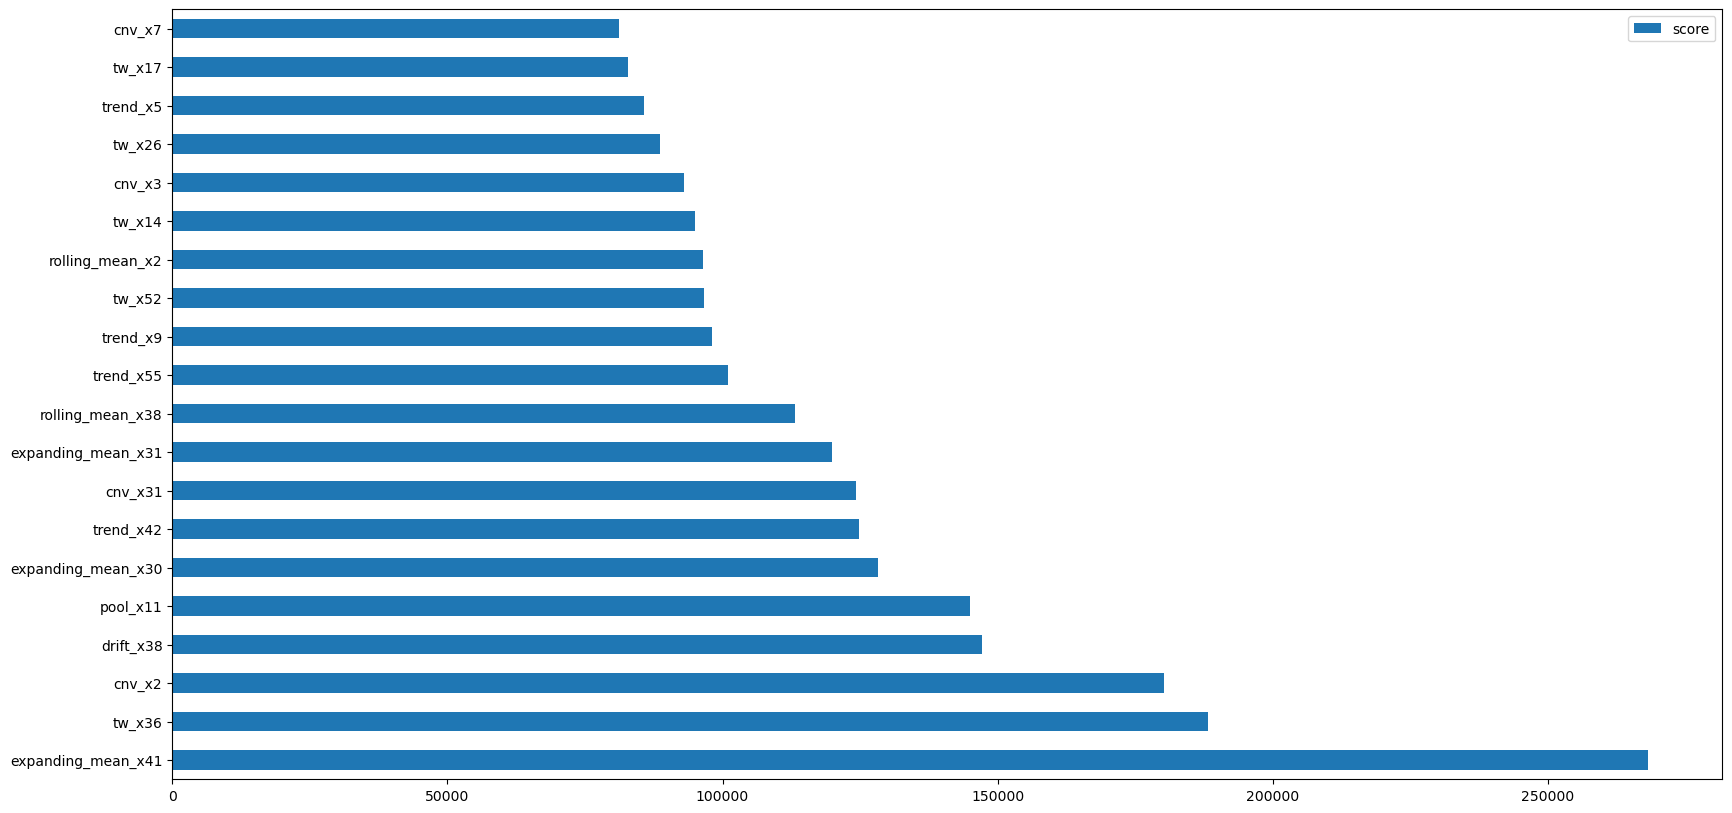

In [159]:
feature_important = model.get_booster().get_score(importance_type='total_cover')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 20 features

In [160]:
import pandas as pd

feature_importance = model.get_booster().get_score(importance_type='total_cover')

data = pd.DataFrame.from_dict(feature_importance, orient='index', columns=["score"])
data = data.nlargest(20, columns="score")

print("Top 20 Feature Importances:")
for feature, importance in data.iterrows():
    print(f"{feature}: {importance['score']}")


Top 20 Feature Importances:
expanding_mean_x41: 268233.15625
tw_x36: 188250.09375
cnv_x2: 180272.453125
drift_x38: 147183.28125
pool_x11: 144929.90625
expanding_mean_x30: 128289.4765625
trend_x42: 124798.5546875
cnv_x31: 124228.9609375
expanding_mean_x31: 119870.3359375
rolling_mean_x38: 113130.6640625
trend_x55: 101000.828125
trend_x9: 98073.25
tw_x52: 96663.8359375
rolling_mean_x2: 96484.8046875
tw_x14: 95036.0625
cnv_x3: 93069.6953125
tw_x26: 88613.2265625
trend_x5: 85702.765625
tw_x17: 82875.4609375
cnv_x7: 81208.90625


In [161]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


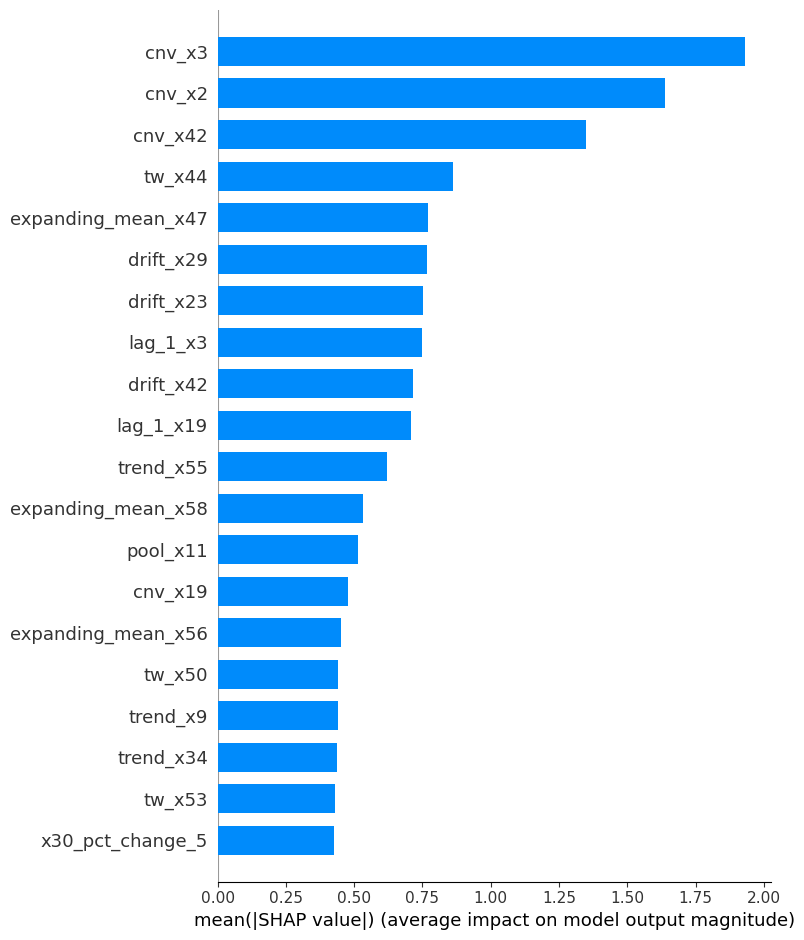

In [162]:
shap.summary_plot(shap_values, X, plot_type="bar")


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


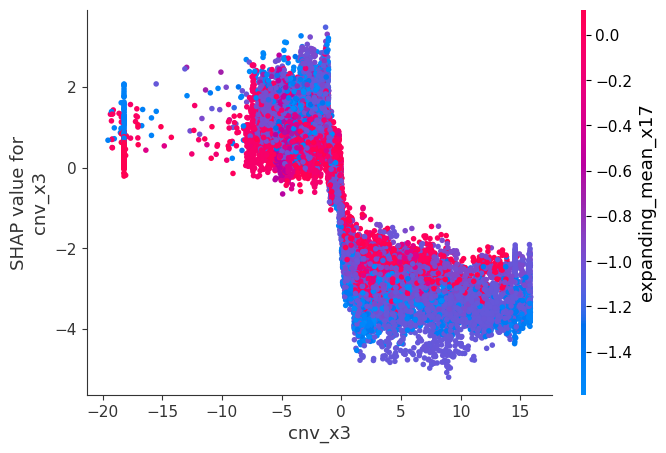

In [134]:
#SHAP feature dependence analysis
# SHAP dependence plot show how the model output varies by feauture value. 

# we pass "cnv_x3" instead of an index because dependence_plot() will find it in X's column names for us
# expanding_mean_x17 was automatically chosen for coloring based on a potential interaction to check that
# the interaction is really in the model see SHAP interaction values below

#EVERY DOT IS A RECORD, SIMPLY AN EVENT
shap_values = shap.TreeExplainer(model).shap_values(X)

shap.dependence_plot("cnv_x3", shap_values, X)


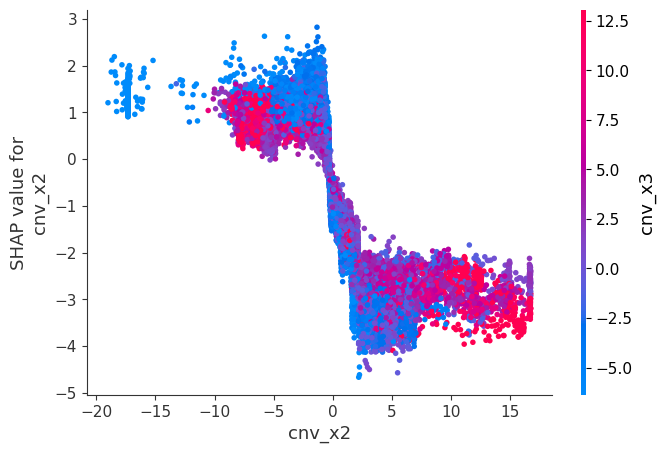

In [125]:
shap.dependence_plot("cnv_x2", shap_values, X)

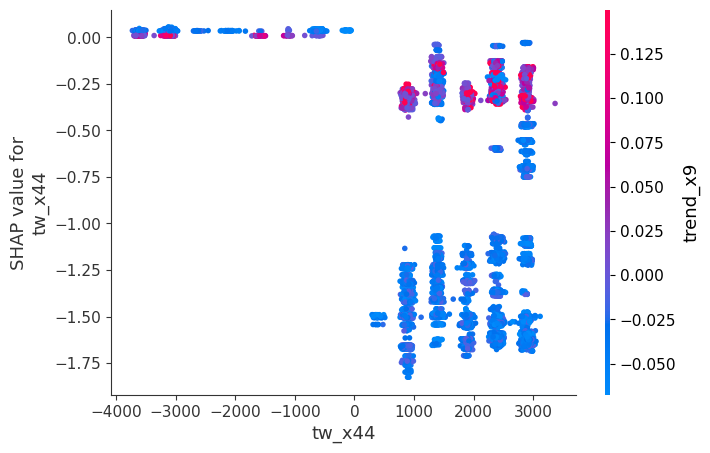

In [127]:
shap.dependence_plot("tw_x44", shap_values, X)